# Task 3: Finding Amplitudes and Latencies of Visual Evoked Potentials (VEP) from EEG data

**Objective:** To preprocess EEG data and find VEP peaks in response to flickering 15 Hz frequency  stimuli (event_id = 3)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## 1. Import Libraries and define basic functions

In [2]:
# Libraries
import pandas as pd
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split

from scipy.signal import butter, filtfilt, freqz, iirnotch
from scipy.signal import find_peaks
import pywt

## 2. Import datasets and create epochs

Each parquet file is read as a dataframe (df0, df1, df2)

In [3]:
df0 = pd.read_parquet('/content/drive/MyDrive/Myelin-H/eeg_data-3/eeg_data-3/vep/0.parquet')
df1 = pd.read_parquet('/content/drive/MyDrive/Myelin-H/eeg_data-3/eeg_data-3/vep/1.parquet')
df2 = pd.read_parquet('/content/drive/MyDrive/Myelin-H/eeg_data-3/eeg_data-3/vep/2.parquet')
df2

,i,timestamp,event_id,eeg_counter,o1,o2,t3,t4
0,0,2024-03-14 09:21:40.760475,1000.0,NaN,NaN,NaN,NaN,NaN
1,1,NaT,NaN,1201.0,0.000000,0.000000,0.000000,0.095839
2,2,2024-03-14 09:21:40.797542,NaN,1201.0,0.012500,0.012500,0.012500,0.108339
3,3,NaT,NaN,1202.0,0.142646,0.000000,0.000000,0.000000
4,4,2024-03-14 09:21:40.798897,NaN,1202.0,0.155146,0.012500,0.012500,0.012500
...,...,...,...,...,...,...,...,...
86745,86745,2024-03-14 09:27:26.877422,NaN,1443.0,0.153793,0.169084,0.124585,0.137738
86746,86746,NaT,NaN,1444.0,0.153805,0.169095,0.124589,0.137747
86747,86747,2024-03-14 09:27:26.892567,NaN,1444.0,0.153815,0.169101,0.124589,0.137744
86748,86748,NaT,NaN,1445.0,0.153807,0.169092,0.124582,0.137734


To show event_id of interest = 3 --> onset of flickering stimuli

In [ ]:
df2_3 = df2[df2['event_id'] == 3]
df2_3

,i,timestamp,event_id,eeg_counter,o1,o2,t3,t4
4994,4994,2024-03-14 09:22:00.751215,3.0,NaN,NaN,NaN,NaN,NaN
5115,5115,2024-03-14 09:22:01.246893,3.0,NaN,NaN,NaN,NaN,NaN
5244,5244,2024-03-14 09:22:01.743774,3.0,NaN,NaN,NaN,NaN,NaN
5367,5367,2024-03-14 09:22:02.244952,3.0,NaN,NaN,NaN,NaN,NaN
5504,5504,2024-03-14 09:22:02.779565,3.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
85087,85087,2024-03-14 09:27:20.275939,3.0,NaN,NaN,NaN,NaN,NaN
85214,85214,2024-03-14 09:27:20.776607,3.0,NaN,NaN,NaN,NaN,NaN
85339,85339,2024-03-14 09:27:21.276629,3.0,NaN,NaN,NaN,NaN,NaN
85474,85474,2024-03-14 09:27:21.811197,3.0,NaN,NaN,NaN,NaN,NaN


 ### Creating epochs dictionary for each trial (parquet file). Epochs are created around the stimuli.

Steps in epoching and reorganizing data for each parquet dataframe:
1. Get dataframe
2. Create empty dictionary which will keep index keys and dataframe values.
dictionary [key] --> {values}
2. Find **stimuli index** for event_id = 1 from dataframe
3. Extract data 0.025 s before stimuli index and 0.25 s after stimuli
  *   Pre stimulus duration = 0.025 seconds (25 ms)
  *   Post stimulus duration = 0.25 seconds (250 ms) --> to observe the VEP

  *   Data to be extracted the from 'o1', 'o2', 't3', and 't4' channels. Data extracted using indexing (num_samples = 5 * sampling rate). Sampling rate = 250 Hz.

4. Add the **extracted eeg segment** into a new epoch dataframe.
5. Make this stimuli index the **[key]** and the eeg epoch dataframe the **{value}** of the dictionary.
6. Iterate over multiple stimuli indexes, get eeg segment, and store in dictionary key and values.



In [7]:
def create_epochs(parquetdf, event_id=3):
    event_df = parquetdf[parquetdf['event_id'] == event_id]

    if event_df.empty:
        print("No events with the specified 'event_id' found.")
        return None

    epochs_data = {}

    for index, row in event_df.iterrows():

      start_index = index - pre_samples
      end_index = index + post_samples
      time_window_df = parquetdf.iloc[start_index: end_index]

      if not time_window_df.empty:
          epochs_data[index] = time_window_df

    return epochs_data


3 parquet files --> 3 epoch dictionaries for stimuli (event_id = 3)

In [8]:
sampling_rate = 250
pre_stimulus = 0.025  # (25 ms)
post_stimulus = 0.25   # (250 ms)

post_samples = int(sampling_rate * post_stimulus)
pre_samples = int(sampling_rate * pre_stimulus)

epochs_dict0 = create_epochs(df0, event_id=3)
epochs_dict1 = create_epochs(df1, event_id=3)
epochs_dict2 = create_epochs(df2, event_id=3)


In [9]:
epochs_dict0

{5346:          i                  timestamp  event_id  eeg_counter        o1  \
 5340  5340                        NaT       NaN        106.0 -0.086721   
 5341  5341 2024-03-27 12:23:48.448805       NaN        106.0 -0.086738   
 5342  5342                        NaT       NaN        107.0 -0.086748   
 5343  5343 2024-03-27 12:23:48.449326       NaN        107.0 -0.086732   
 5344  5344                        NaT       NaN        108.0 -0.086703   
 ...    ...                        ...       ...          ...       ...   
 5403  5403                        NaT       NaN        137.0 -0.086749   
 5404  5404                        NaT       NaN        137.0 -0.086742   
 5405  5405                        NaT       NaN        138.0 -0.086716   
 5406  5406 2024-03-27 12:23:48.703201       NaN        138.0 -0.086707   
 5407  5407                        NaT       NaN        139.0 -0.086739   
 
             o2        t3        t4  
 5340 -0.093810 -0.085544 -0.107290  
 5341 -0.093817 

## 3. Preprocessing signals

## Preprocessing functions:

**1. Data Imputation (to fill missing data)**

**2. High pass filter (to remove low frequency noise)**

**3. Notch filter (to filter out 60 Hz powerline noise)**

**4. Bandpass filter (to select frequency of interest: 1 Hz - 40 Hz)**

**5. Wavelet Transform Denoising (to remove noise in time-frequency domain)**

6. Lowpass filter

7. Baseline correction (to bring signals to stable baseline)

In [11]:
def denoise_signal(signal, wavelet_name='db4', level=None, thresholding_strategy='soft', threshold_multiplier=1.0):

    coeff = pywt.wavedec(signal, wavelet_name, mode='per', level=level)
    sigma = np.median(np.abs(coeff[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal))) * threshold_multiplier
    coeff[1:] = [pywt.threshold(i, value=threshold, mode=thresholding_strategy) for i in coeff[1:]]

    # Reconstruct the signal using the modified coefficients
    recon_signal = pywt.waverec(coeff, wavelet_name, mode='per')
    return recon_signal


In [12]:
# defining functions for pre-processing

# bandpass
def bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# notch filter
def notch_filter(data, fs, f0, Q=30):
    w0 = f0 / (fs / 2)
    b, a = iirnotch(w0, Q)
    filtered_signal = filtfilt(b, a, data)
    return filtered_signal

# baseline correction
def apply_baseline_correction(data, key, channel_name):

  start_index = key - pre_samples
  baseline_data = data.loc[start_index:key, channel_name]
  #corrected_data = data.copy()
  corrected_data = data[channel_name] - baseline_data.mean()
  return corrected_data

# high-pass filter
def high_pass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high')
    y = filtfilt(b, a, data)
    return y


In [32]:
def preprocessdata(dictionary_data):
    fs = 250  # Sampling frequency
    f0 = 50   # Frequency to notch out

    processed_data = {}
    for key in dictionary_data:

      df = dictionary_data[key]
      channel_df = pd.DataFrame(index=df.index)

      for channel in ['o1', 'o2', 't3', 't4']:

            # Impute missing data
            #print(df[channel])
            df[channel].interpolate(method='linear', inplace=True)
            df[channel].fillna(method='bfill', inplace=True)  # Backward fill if still NaNs at the start
            df[channel].fillna(method='ffill', inplace=True)  # Forward fill if still NaNs at the end

            # Baseline correction
            #corrected_channel = apply_baseline_correction(df, key, channel)

            # Notch filtering
            notch_filtered_channel = notch_filter(df[channel], fs, f0)

            # high pass filtering
            hp_filtered_channel = high_pass_filter(notch_filtered_channel, 10, fs, order=2)

            # # Bandpass filtering
            bandpass_filtered_channel = bandpass_filter(notch_filtered_channel, 1, 40, fs)

            denoised_emg = denoise_signal(bandpass_filtered_channel, wavelet_name='db4', threshold_multiplier=1)

            # Store processed channel back in new DataFrame
            channel_df[channel] = denoised_emg

        # Store the DataFrame with all processed channels into the dictionary
      processed_data[key] = channel_df

      #break;

    return processed_data

Processing signals for each epoch in each dictionary

In [33]:
epochs_dict0_processed = preprocessdata(epochs_dict0)
epochs_dict1_processed = preprocessdata(epochs_dict1)
epochs_dict2_processed = preprocessdata(epochs_dict2)
epochs_dict2_processed

Streaming output truncated to the last 5000 lines.
<ipython-input-32-0096835f85b2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[channel].fillna(method='ffill', inplace=True)  # Forward fill if still NaNs at the end
<ipython-input-32-0096835f85b2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[channel].interpolate(method='linear', inplace=True)
<ipython-input-32-0096835f85b2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

{4994:                 o1        o2        t3            t4
 4988 -6.127315e-06 -0.000003 -0.000006 -6.013254e-06
 4989 -4.679554e-06 -0.000006 -0.000011 -1.155238e-05
 4990 -3.871855e-06 -0.000015 -0.000015 -1.779958e-05
 4991 -2.334231e-06 -0.000017 -0.000015 -2.077743e-05
 4992  4.060371e-07 -0.000014 -0.000010 -1.912142e-05
 ...            ...       ...       ...           ...
 5051 -1.025864e-05 -0.000013  0.000012  1.100022e-06
 5052 -1.521464e-05 -0.000016  0.000008 -9.706418e-07
 5053 -1.482340e-05 -0.000015  0.000006 -1.446275e-06
 5054 -8.926657e-06 -0.000010  0.000006 -2.240467e-07
 5055 -3.763621e-06 -0.000006  0.000005 -1.028378e-07
 
 [68 rows x 4 columns],
 5115:             o1        o2            t3            t4
 5109 -0.000012 -0.000010 -8.057366e-06 -5.814412e-06
 5110 -0.000015 -0.000011 -6.129990e-06 -3.501097e-06
 5111 -0.000026 -0.000017 -2.942756e-06 -2.787011e-06
 5112 -0.000030 -0.000018  2.337208e-06 -8.204895e-07
 5113 -0.000030 -0.000016  8.992089e-06  2.6

### Visualising original and processed signals

Creating time axis for epochs

In [34]:
total_samples = post_samples + pre_samples
time_axis = np.linspace(-pre_stimulus, post_stimulus, total_samples, endpoint=False)

#time_axis

In [35]:
def plot_channels_with_time_axis(original_df, processed_df, time_axis, key, df_name):
  channel_info = [
        {'channels': ['o1', 'o2'], 'colors': ['limegreen', 'darkgreen']},
        {'channels': ['t3', 't4'], 'colors': ['skyblue', 'teal']}
    ]

  fig, axs = plt.subplots(2, 2, figsize=(12, 10))

  for i, info in enumerate(channel_info):
    for j, channel in enumerate(info['channels']):
      color = info['colors'][j]

      # Original data
      axs[i, 0].plot(time_axis, original_df[channel], label=f'Original {channel}', color=color)
      axs[i, 0].set_title(f'{df_name} Original Signal - {info["channels"]}')
      axs[i, 0].set_xlabel('Time (seconds)')
      axs[i, 0].set_ylabel('Amplitude')

      # Set time axis
      axs[i, 0].set_xlim([time_axis.min(), time_axis.max()])
      axs[i, 0].set_xticks(np.linspace(time_axis.min(), time_axis.max(), num=5))

      # Processed data
      axs[i, 1].plot(time_axis, processed_df[channel], label=f'Processed {channel}', color=color)
      axs[i, 1].set_title(f'{df_name} Processed Signal - {info["channels"]}')
      axs[i, 1].set_xlabel('Time (seconds)')

      axs[i, 1].set_xlim([time_axis.min(), time_axis.max()])
      axs[i, 1].set_xticks(np.linspace(time_axis.min(), time_axis.max(), num=5))

  for ax in axs.flat:
    ax.axvline(x=0, color='red', linestyle='--', label='Stimulus Event')
    ax.legend()

  plt.tight_layout()
  plt.show()


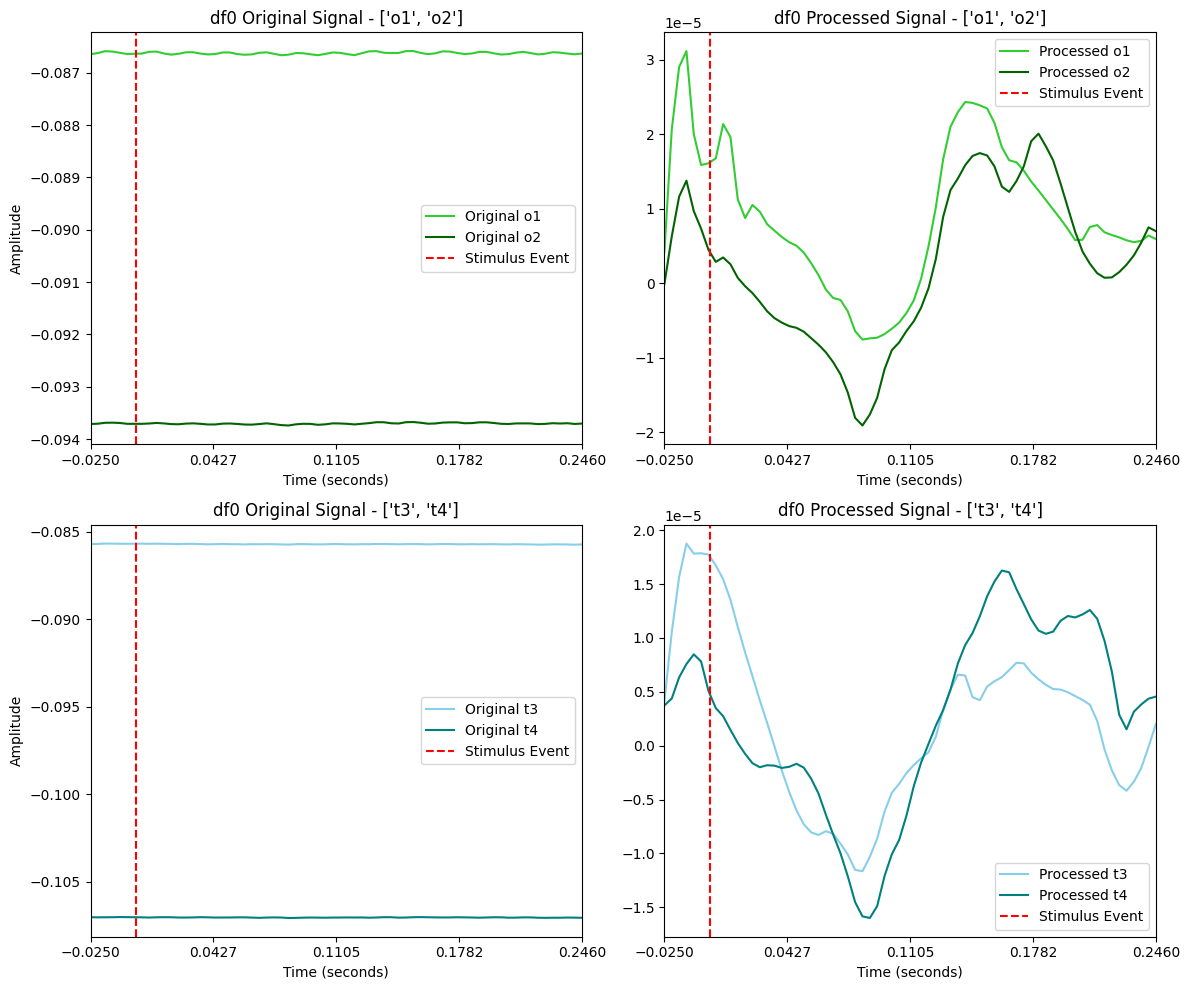

In [36]:
first_key = list(epochs_dict0_processed.keys())[5]        # Get the first key from dictionary
first_df0 = epochs_dict0[first_key]                       # Get the corresponding original DataFrame
first_processed_df0 = epochs_dict0_processed[first_key]   # Get the corresponding processed DataFrame
plot_channels_with_time_axis(first_df0, first_processed_df0, time_axis, first_key, df_name = "df0")

# 4. Creating averaged single trial dataset (event_id = 3)

Each dictionary corresponds to a single trial, within which all the epochs were averaged to create an averaged epoch dataframe

In [37]:
def average_epochs(epochs_dict):

    sum_df = None
    num_epochs = len(epochs_dict)

    keys_list = list(epochs_dict.keys())

    # Iterate over each epoch's DataFrame in the dictionary
    for key in keys_list:
      epoch_df = epochs_dict[key][['o1', 'o2', 't3', 't4']]
      epoch_df = epoch_df.fillna(0)
      epoch_df_reset = epoch_df.reset_index(drop=True)

      if sum_df is None:
        sum_df = epoch_df.copy()
        sum_df_reset = sum_df.reset_index(drop=True)
        #print(sum_df)
      else:
        sum_df_reset += epoch_df_reset     # Add each subsequent DataFrame to the sum_df

    averaged_epoch = sum_df_reset / num_epochs    # accumulating all sum dataframes and dividing by no. of epochs to get average

    return averaged_epoch

In [38]:
avg_epochs_dict0 = average_epochs(epochs_dict0_processed)
avg_epochs_dict1 = average_epochs(epochs_dict1_processed)
avg_epochs_dict2 = average_epochs(epochs_dict2_processed)
avg_epochs_dict2

,o1,o2,t3,t4
0,3.460257e-07,1.401325e-06,-1.593196e-06,-1.123268e-06
1,-2.151200e-07,1.219330e-06,-1.573257e-06,-1.120321e-06
2,-8.325075e-07,9.339054e-07,-1.352488e-06,-8.422376e-07
3,-1.030948e-06,8.778909e-07,-1.235274e-06,-6.333689e-07
4,-5.013411e-07,1.261505e-06,-1.223970e-06,-4.694860e-07
...,...,...,...,...
63,-1.843195e-06,-1.405826e-06,8.614135e-08,9.185341e-07
64,-1.726242e-06,-1.366878e-06,1.211698e-07,7.024699e-07
65,-1.487351e-06,-1.365020e-06,2.204809e-07,5.464482e-07
66,-9.918150e-07,-1.237539e-06,4.430351e-07,4.965291e-07


In [ ]:
# @title
# not need
def avg_proc_epochs(avg_epoch_data):
  fs = 250  # Sampling frequency
  f0 = 60   # Frequency to notch out

  channel_df = pd.DataFrame(index=avg_epoch_data.index)

  for channel in ['o1', 'o2', 't3', 't4']:

    if channel in avg_epoch_data.columns:

      # Notch filtering
      notch_filtered_channel = notch_filter(avg_epoch_data[channel], fs, f0)

      # Bandpass filtering
      #bandpass_filtered_channel = bandpass_filter(notch_filtered_channel, 0.1, 20, fs)
      bandpass_filtered_channel = high_pass_filter(notch_filtered_channel, 0.0001, fs)

      # Store processed channel back in new DataFrame
      channel_df[channel] = bandpass_filtered_channel

  return channel_df

In [ ]:
# @title
# no need
avg_proc_epochs_dict0 = avg_proc_epochs(avg_epochs_dict0)
avg_proc_epochs_dict1 = avg_proc_epochs(avg_epochs_dict1)
avg_proc_epochs_dict2 = avg_proc_epochs(avg_epochs_dict2)
avg_proc_epochs_dict2

,o1,o2,t3,t4
0,5.066788e-06,1.368696e-05,-0.000026,-0.000020
1,4.024779e-06,1.251170e-05,-0.000025,-0.000020
2,2.307125e-06,1.124925e-05,-0.000025,-0.000020
3,2.006852e-06,1.134505e-05,-0.000025,-0.000020
4,3.008932e-06,1.191691e-05,-0.000025,-0.000019
5,4.125224e-06,1.230868e-05,-0.000024,-0.000018
6,3.680932e-06,1.175085e-05,-0.000024,-0.000018
7,3.196883e-06,1.116349e-05,-0.000024,-0.000018
8,1.429151e-06,9.838164e-06,-0.000025,-0.000018
9,2.214191e-07,9.012969e-06,-0.000024,-0.000018


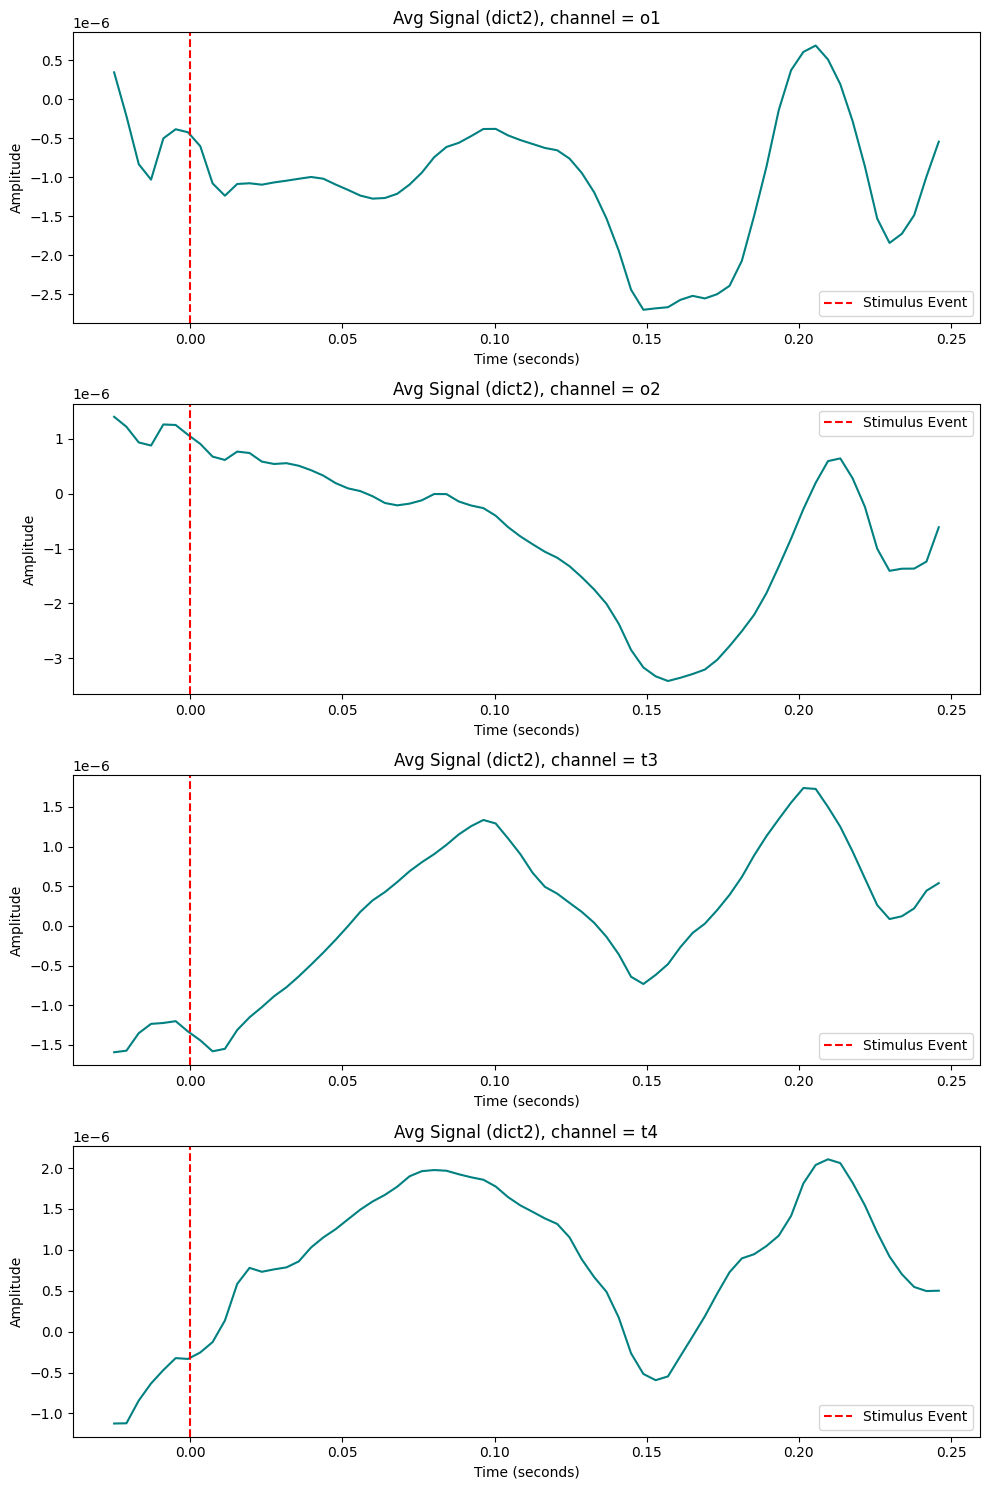

In [39]:
channels = ['o1', 'o2', 't3', 't4']

fig, axs = plt.subplots(4, 1, figsize=(10, 15))

for i in range(len(channels)):
  channel = channels[i]
  axs[i].plot(time_axis, avg_epochs_dict2[channel], color = 'teal')
  axs[i].set_title(f'Avg Signal (dict2), channel = {channel}')
  axs[i].set_xlabel('Time (seconds)')
  axs[i].set_ylabel('Amplitude')

for ax in axs.flat:
    ax.axvline(x=0, color='red', linestyle='--', label='Stimulus Event')
    ax.legend()

plt.tight_layout()
plt.show()


## 5. Creating averaged trials dataframe from all trials

Using the averaged dataframes above, all of them were combined and averaged to create one average dataframe

In [40]:
def average_dicts(epochs_dict_list):
  sum_df = None
  num_epochs = 0

  for ep_dict in epochs_dict_list:
    num_epochs1 = len(ep_dict)

    keys_list = list(ep_dict.keys())

    for key in keys_list:
      epoch_df = ep_dict[key][['o1', 'o2', 't3', 't4']]
      epoch_df = epoch_df.fillna(0)
      epoch_df_reset = epoch_df.reset_index(drop=True)

      if sum_df is None:
        sum_df = epoch_df.copy()
        sum_df_reset = sum_df.reset_index(drop=True)

      else:
        sum_df_reset += epoch_df_reset

    num_epochs += num_epochs1
    print(num_epochs)

  averaged_epoch = sum_df_reset / num_epochs # finding average of all values

  return averaged_epoch

In [41]:
ep_dicts = [epochs_dict0_processed, epochs_dict1_processed, epochs_dict2_processed]
avg_proc_VEP = average_dicts(ep_dicts)
avg_proc_VEP

320
620
840


,o1,o2,t3,t4
0,1.597374e-07,2.441848e-07,2.228365e-06,-2.973539e-07
1,-1.780088e-07,-5.054604e-09,7.846138e-07,-3.409991e-07
2,-3.862384e-07,-1.133995e-07,1.089837e-06,-3.006486e-07
3,-3.076089e-07,-7.466752e-08,8.936619e-07,-2.000508e-07
4,1.116140e-07,1.727084e-07,5.208111e-07,-1.943566e-08
...,...,...,...,...
63,2.128783e-06,2.114616e-06,2.426683e-06,2.211391e-07
64,1.804484e-06,1.738823e-06,2.714706e-06,6.286462e-08
65,1.497906e-06,1.413369e-06,2.605508e-06,-1.726538e-08
66,1.242783e-06,1.221410e-06,2.124020e-06,1.592647e-08


### Visualising averaged signals

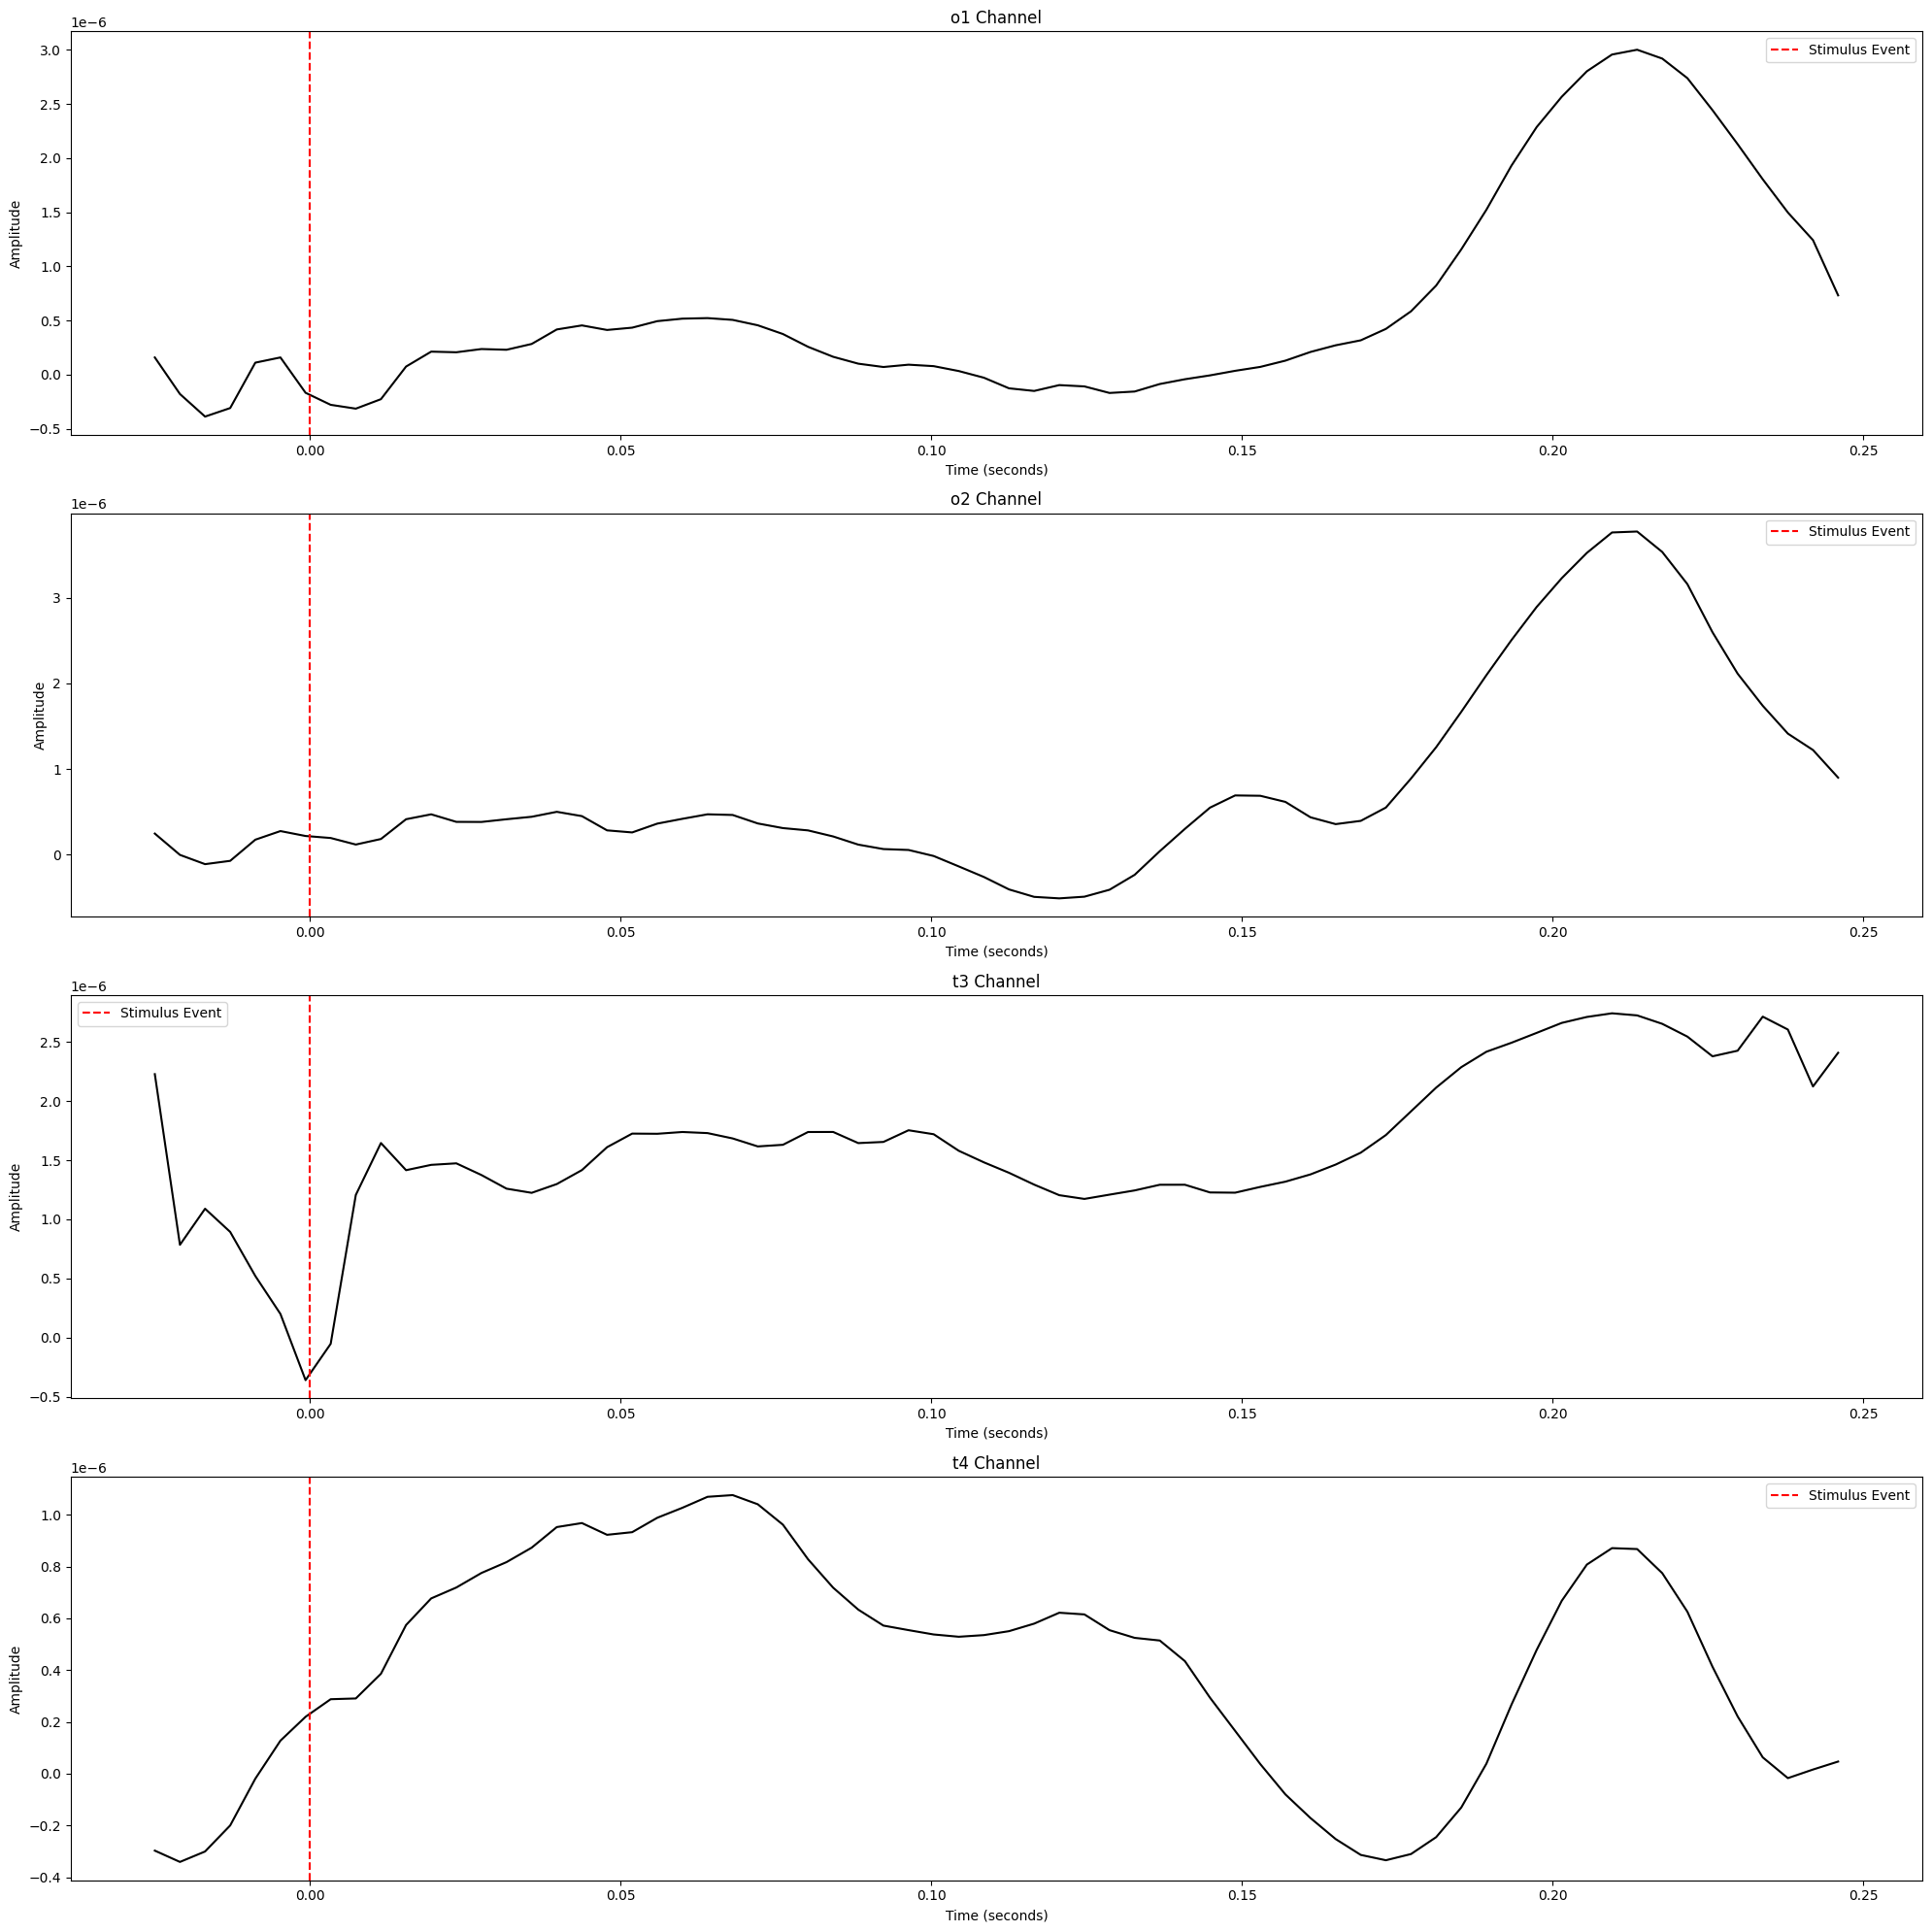

In [42]:
channels = ['o1', 'o2', 't3', 't4']

fig, axs = plt.subplots(len(channels), 1, figsize=(20, 20))

for i, channel in enumerate(channels):

    ax = axs[i]
    ax.plot(time_axis, avg_proc_VEP[channel], color='black')
    ax.set_title(f'{channel} Channel')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')

for ax in axs.flat:
    ax.axvline(x=0, color='red', linestyle='--', label='Stimulus Event')
    ax.legend()

plt.tight_layout()
plt.show()

## 6. Detecting VEP from average epochs data and average dictionaries data

Functions

In [43]:
def detect_peak(signal, height):

    inverted_signal = -signal  # Invert signal to find negative peaks as positive peaks
    indices, properties = find_peaks(inverted_signal, height=height)
    print(indices)
    return indices, -properties["peak_heights"]


In [52]:
def find_VEP(avg_dataframe):
    channels = ['o1', 'o2', 't3', 't4']
    amp_lat_values = pd.DataFrame()

    for ch in channels:
        peak_indices, peak_values = detect_peak(avg_dataframe[ch], 1.5e-7)  # height threshold

        if len(peak_values) > 0:
            min_peak_height = np.min(peak_values)  # Find the most negative peak
            min_peak_index = peak_indices[np.argmin(peak_values)]

            latency = time_axis[10:-7][min_peak_index]


            temp_df = pd.DataFrame({
                'Channel': [ch],
                'Amplitude': [min_peak_height],            # store amplitude
                'Latency': [latency],                      # store latency
                'Index': [min_peak_index]                  # Store the index of the peak
            })

            amp_lat_values = pd.concat([amp_lat_values, temp_df], ignore_index=True)

    if not amp_lat_values.empty:
        amp_lat_values.set_index('Channel', inplace=True)

    return amp_lat_values


### Finding peaks for single averaged trial (dict0, dict1, dict2)


In [53]:
def plot_peaks(VEP_dataset_list):

  fig, axs = plt.subplots(4, 3, figsize=(15, 20), constrained_layout=True)

  for j in range(len(VEP_dataset_list)):
    VEP_dataset = VEP_dataset_list[j]

    amp_lat_values = find_VEP(VEP_dataset)

    for i, channel in enumerate(['o1', 'o2', 't3', 't4']):
      ax = axs[i, j]
      ax.plot(time_axis[10:-10], VEP_dataset[channel], label=f'Signal - {channel}')
      if channel in amp_lat_values.index:
          peak_amplitude = amp_lat_values.at[channel, 'Amplitude']
          latency = amp_lat_values.at[channel, 'Latency']
          ax.scatter(latency, peak_amplitude, color='red', label='VEP peak')
          ax.axvline(x=latency, color='orange', linestyle='--', label=f'Latency at {latency:.3f} s')

      ax.set_title(f'Channel: {channel}, dict{j}')
      ax.set_xlabel('Time (seconds)')
      ax.set_ylabel('Amplitude')
      ax.legend()


[25]
[26]
[26]
[41]
[34]
[ 4 18 36]
[]
[18 38]
[ 2 11 33 38]
[13 35]
[33]
[34]


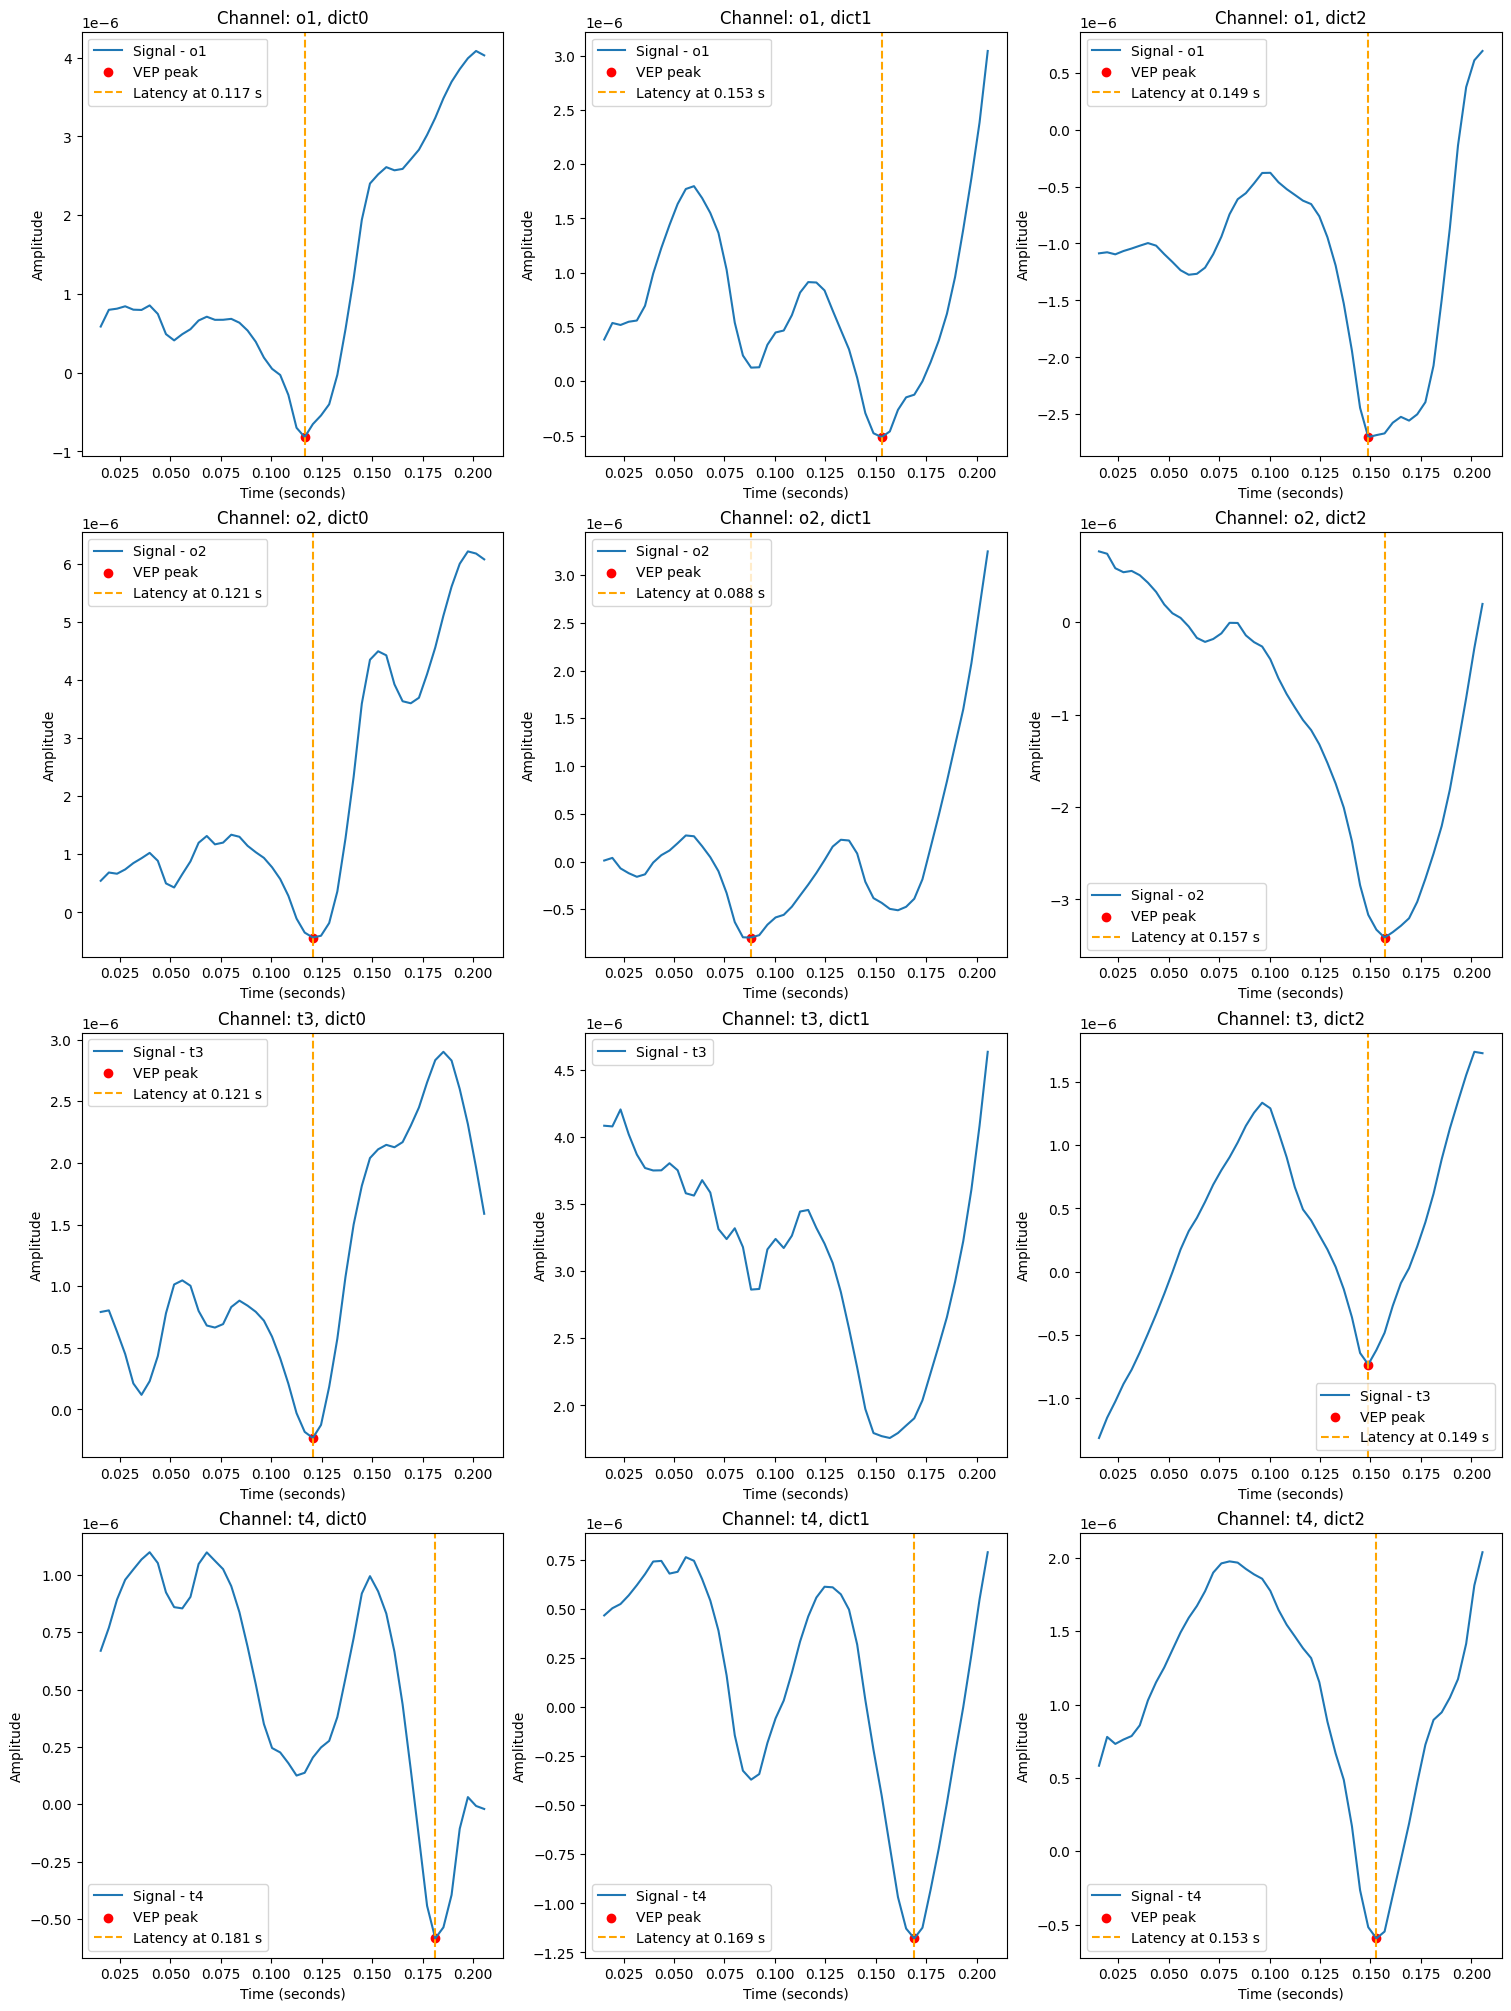

In [54]:
avg_dict_list = [avg_epochs_dict0[10:-10], avg_epochs_dict1[10:-10], avg_epochs_dict2[10:-10]]  # removing the 40 ms pre stimulus duration and 40 ms from signal end
plot_peaks(avg_dict_list)

In [60]:
peaks_table1 = find_VEP(avg_epochs_dict0[10:-10])
peaks_table1 = peaks_table1.T
peaks_table1

[25]
[26]
[26]
[41]


Channel,o1,o2,t3,t4
Amplitude,-8.199917e-07,-4.331786e-07,-2.320714e-07,-5.843121e-07
Latency,1.165441e-01,1.205882e-01,1.205882e-01,1.812500e-01
Index,2.500000e+01,2.600000e+01,2.600000e+01,4.100000e+01


In [62]:
peaks_table2 = find_VEP(avg_epochs_dict1[10:-10])
peaks_table2 = peaks_table2.T
peaks_table2

[34]
[ 4 18 36]
[]
[18 38]


Channel,o1,o2,t4
Amplitude,-5.145976e-07,-7.963767e-07,-0.000001
Latency,1.529412e-01,8.823529e-02,0.169118
Index,3.400000e+01,1.800000e+01,38.000000


In [63]:
peaks_table3 = find_VEP(avg_epochs_dict2[10:-10])
peaks_table3 = peaks_table3.T
peaks_table3

[ 2 11 33 38]
[13 35]
[33]
[34]


Channel,o1,o2,t3,t4
Amplitude,-0.000003,-0.000003,-7.326005e-07,-5.935588e-07
Latency,0.148897,0.156985,1.488971e-01,1.529412e-01
Index,33.000000,35.000000,3.300000e+01,3.400000e+01


### Finding peaks for averaged trial

In [56]:
def plot_peaks(VEP_dataset):

  amp_lat_values = find_VEP(VEP_dataset)
  fig, axs = plt.subplots(4, 1, figsize=(15, 20))

  for i, channel in enumerate(['o1', 'o2', 't3', 't4']):
    ax = axs[i]
    ax.plot(time_axis[10:-10], VEP_dataset[channel], label=f'Signal - {channel}')
    if channel in amp_lat_values.index:
        peak_amplitude = amp_lat_values.at[channel, 'Amplitude']
        latency = amp_lat_values.at[channel, 'Latency']
        ax.scatter(latency, peak_amplitude, color='red', label='Most Negative Peak')
        ax.axvline(x=latency, color='orange', linestyle='--', label=f'Latency at {latency:.3f} s')

    ax.set_title(f'Channel: {channel}')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.legend()

[28]
[26]
[]
[39]


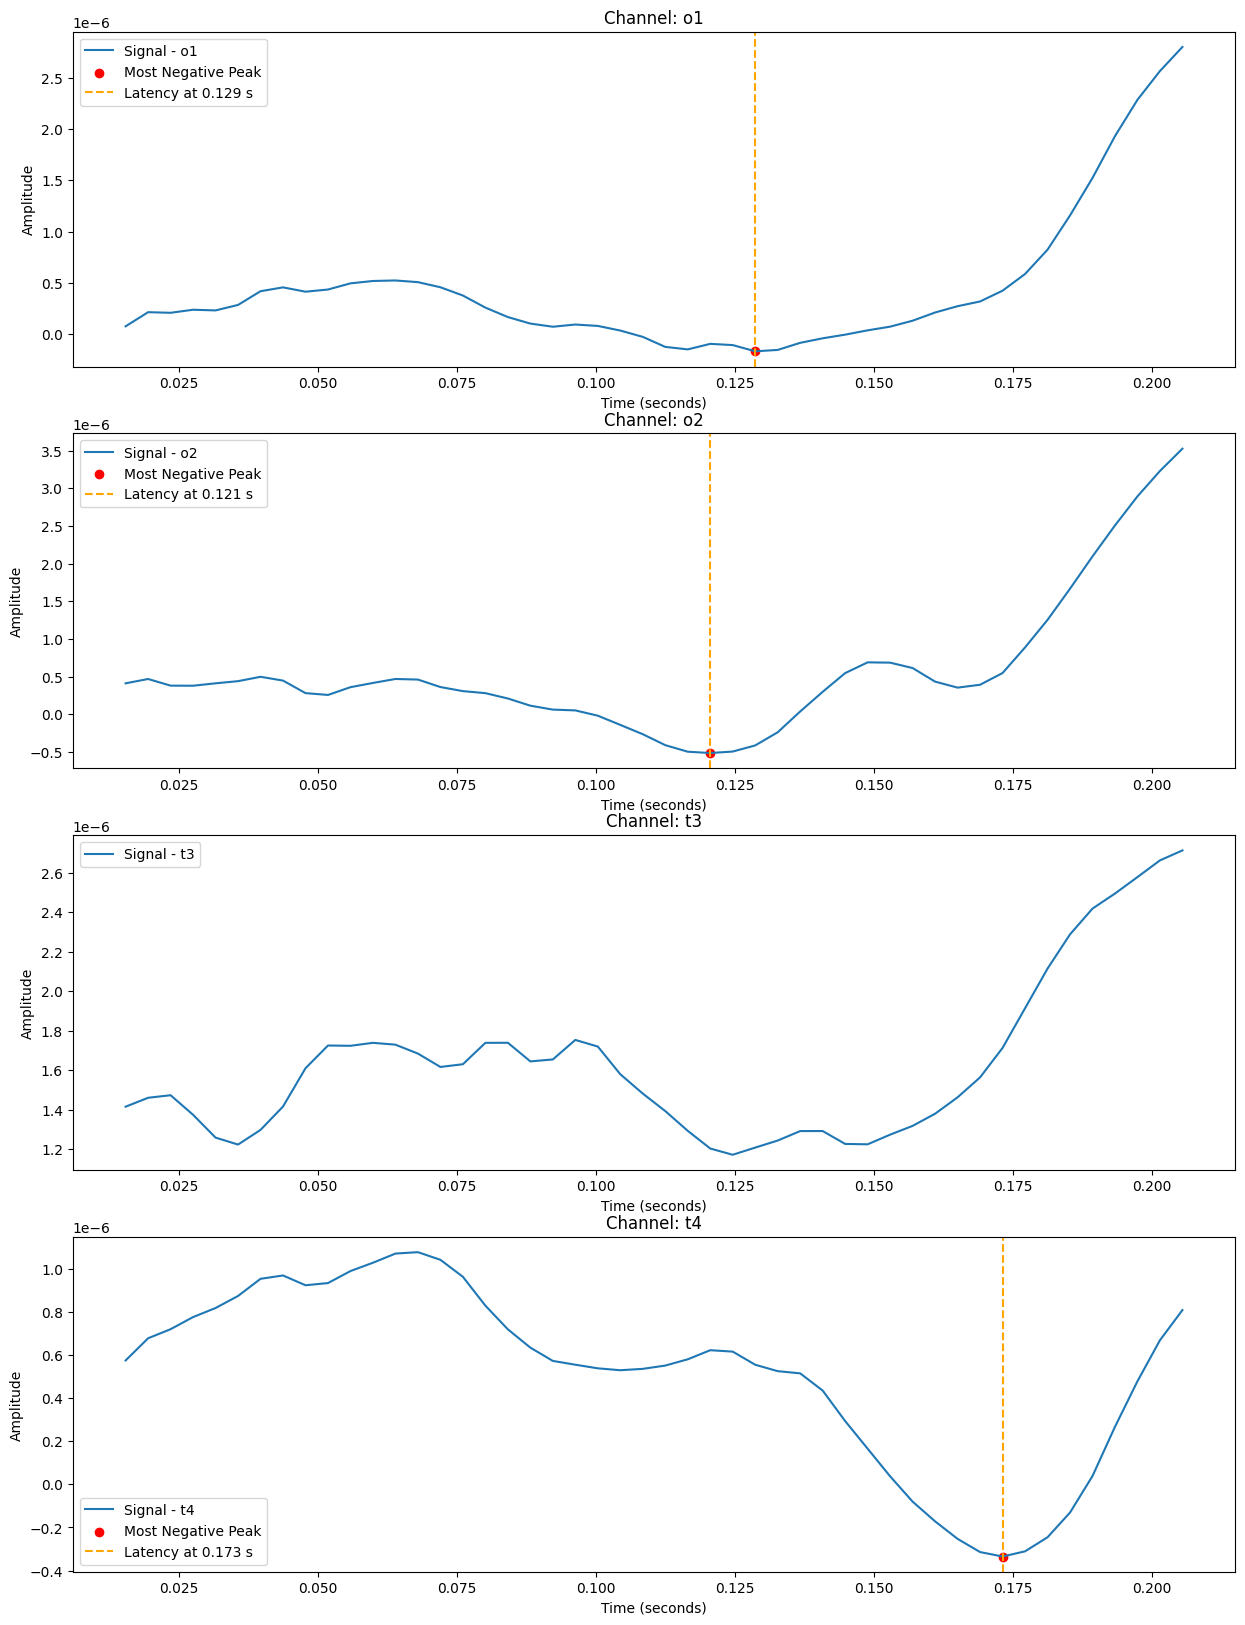

In [57]:
plot_peaks(avg_proc_VEP[10:-10])

In [58]:
peaks_table4 = find_VEP(avg_proc_VEP[10:-10])
peaks_table4 = peaks_table4.T
peaks_table4

[28]
[26]
[]
[39]


Channel,o1,o2,t4
Amplitude,-1.682060e-07,-5.134233e-07,-3.344624e-07
Latency,1.286765e-01,1.205882e-01,1.731618e-01
Index,2.800000e+01,2.600000e+01,3.900000e+01


# 7. Observations/Improvements


*   Peaks numerically too small ( ~ 0.1 uV), peak too small to detect
*   VEP peak visible to an extent, need further denoising techniques with more robust preprocessing techniques
*   Could spot outliers by clustering technique, and remove them to increase signal to noise ratio while averaging
*    Need to adjust thresholding to detect negative peaks accurately

